
# Spot resources Analytics

Here we perform some initial process and analysis on the dataset.

---




With static dataset, e.g. load the grabbed data.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn
%matplotlib inline
import time
import dateutil.parser

In [25]:
# The filtered file make sure to use the fi
#filename = './aws-recent-filtered.csv'
filename = './data/subset.csv'

In [54]:
start = time.time()
# parse the data file and extra the results
df = pd.read_csv(filename)
print(time.time()-start)
df.head(3)

1.9640190601348877


,TimeStamp,AvailabilityZone,InstanceType,SpotPrice
0,2016-12-12 10:46:15,ap-northeast-2a,m4.large,0.0353
1,2016-12-12 10:46:05,ap-northeast-2a,m4.large,0.0351
2,2016-12-12 10:45:05,ap-northeast-2c,m4.large,0.0244


In [55]:
df['TimeStamp'] = pd.to_datetime(df.TimeStamp)
df.index = df.TimeStamp
df = df.drop('TimeStamp', axis=1)
df= df.sort_index()
df.head(3)

,AvailabilityZone,InstanceType,SpotPrice
TimeStamp,,,
2016-10-11 11:09:34,ap-northeast-2c,i2.4xlarge,1.136
2016-10-11 11:09:34,ap-northeast-2a,i2.4xlarge,1.136
2016-10-11 11:10:00,ap-northeast-2a,i2.2xlarge,0.568


----------

In [28]:
print (len(df))
print (df['InstanceType'].unique())
print (df['AvailabilityZone'].unique())


1496361
['m4.large' 'm4.xlarge' 'm4.2xlarge' 'm4.4xlarge' 'm4.10xlarge'
 'm4.16xlarge' 'r3.large' 'r3.xlarge' 'r3.2xlarge' 'r3.4xlarge'
 'r3.8xlarge' 'x1.16xlarge' 'x1.32xlarge' 'i2.xlarge' 'i2.2xlarge'
 'i2.4xlarge' 'i2.8xlarge' 'c4.large' 'c4.xlarge' 'c4.2xlarge' 'c4.4xlarge'
 'c4.8xlarge' 'd2.xlarge' 'd2.2xlarge' 'd2.4xlarge' 'd2.8xlarge']
['ap-northeast-2a' 'ap-northeast-2c']


## Hypothesis #2

For each machine type there exists a region that is more favorable to use, as the market volatility is very low and the prices tend to stay cheaper than the other regions.

With in proving this hypothesis users will be able to find the best region they should be bidding in, as long as latency is not an issue for them.

Data Science tools & Techniques: We can use clustering and classification methods.


In [56]:
def corrGraph(title, df):
    corr_df = df.corr()
    mask = np.zeros_like(corr_df)
    mask[np.triu_indices_from(mask)] = True
    seaborn.heatmap(corr_df, cmap='RdYlGn_r', vmax=1.0, vmin=-1.0 , mask = mask, linewidths=2.5)
    plt.yticks(rotation=0) 
    plt.title(title)
    plt.xticks(rotation=90) 
    plt.show()


In [57]:
# Some info about the data
print (df.index.min())
print (df.index.max())
print(df.index.max()- df.index.min()) 
#df = df.truncate(before='2015-01-16', after='2015-3-18')
df.head(3)

2016-10-11 11:09:34
2016-12-12 10:46:17
61 days 23:36:43


,AvailabilityZone,InstanceType,SpotPrice
TimeStamp,,,
2016-10-11 11:09:34,ap-northeast-2c,i2.4xlarge,1.136
2016-10-11 11:09:34,ap-northeast-2a,i2.4xlarge,1.136
2016-10-11 11:10:00,ap-northeast-2a,i2.2xlarge,0.568


In [58]:
depa = df.groupby(['AvailabilityZone', 'InstanceType'])

In [59]:
#depa = awsResampler(df)
# Initialize dictionary of all combos of  empty dfs we want to graph and corr
zonedfs={}
typedfs={}
for item in df['InstanceType'].unique():
    typedfs.update({item: pd.DataFrame()})
for item in df['AvailabilityZone'].unique():
    zonedfs.update({item: pd.DataFrame()})

#Fill zonedfs with dataframes of all machines in that zone pricing
for name, group in depa:
    #We have to create the data frame by merging the rows and the first run we need our first row
    if zonedfs[name[0]].empty:
        #RESAMPLE DATA HOURLY getting the avg of the hour
        zonedfs[name[0]] = group
        zonedfs[name[0]] = zonedfs[name[0]].resample('H').mean()
        zonedfs[name[0]] = zonedfs[name[0]].fillna(method="ffill")
        #zonedfs[name[0]] = zonedfs[name[0]].drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        #Remove index so that you can merge
        zonedfs[name[0]] = zonedfs[name[0]].reset_index()
        #print(zonedfs[name[0]].head(40) )
        zonedfs[name[0]].rename(columns = {'SpotPrice':name[1]}, inplace = True)

    else:
        #RESAMPLE DATA HOURLY getting the avg of the hour
        group1 = group.resample('H').mean()
        group1 = group1.fillna(method="ffill")
        #print(zonedfs[name[0]].head(20) )
        #group1 = group.drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        group1.rename(columns = {'SpotPrice':name[1]}, inplace = True)    
        #Remove index so that you can merge
        group1 = group1.reset_index()
        #print(group1.head(20))
        zonedfs[name[0]] = zonedfs[name[0]].merge(group1,how='right')


#Fill typedfs with dataframes of all machines in that zone pricing
for name, group in depa:
    if typedfs[name[1]].empty:
        typedfs[name[1]] = group
        typedfs[name[1]] = typedfs[name[1]].drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        typedfs[name[1]].rename(columns = {'SpotPrice':name[0]}, inplace = True)
        typedfs[name[1]] = typedfs[name[1]].reset_index()
    else:
        group1 = group.drop('InstanceType', axis=1).drop(['AvailabilityZone'],axis=1)
        group1.rename(columns = {'SpotPrice':name[0]}, inplace = True)
        group1 = group1.reset_index()
        typedfs[name[1]] = typedfs[name[1]].merge(group1,how='right')


In [60]:
# Reindex time by timestamp
for key in typedfs:
    typedfs[key].index = typedfs[key].TimeStamp
    typedfs[key]       = typedfs[key].drop(['TimeStamp'],axis=1)

for key in zonedfs:
    zonedfs[key].index = zonedfs[key].TimeStamp
    zonedfs[key]       = zonedfs[key].drop(['TimeStamp'],axis=1)

## Correlations of timeseries

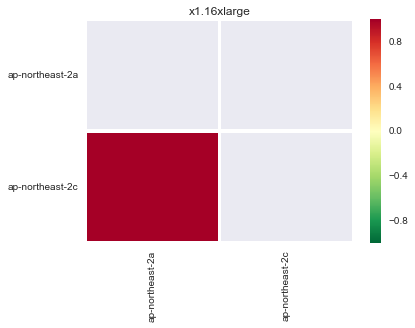

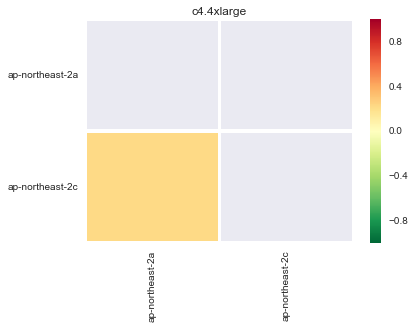

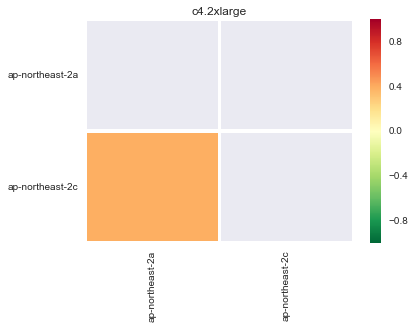

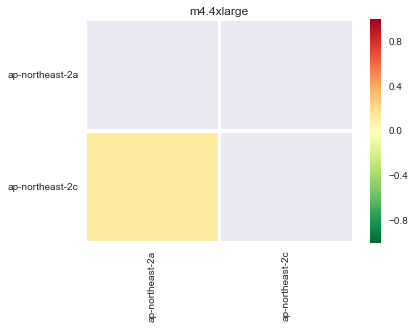

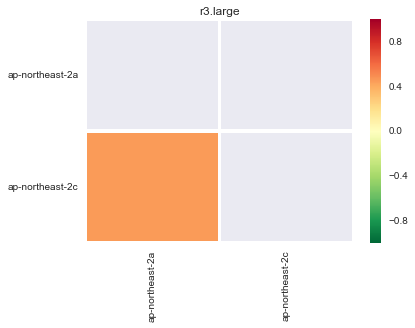

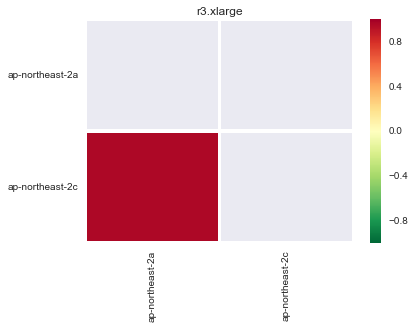

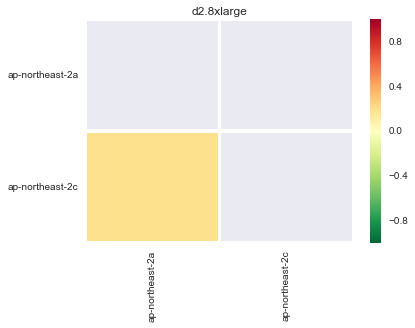

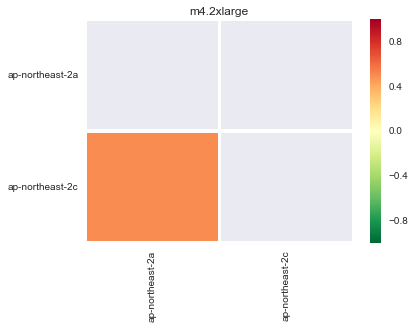

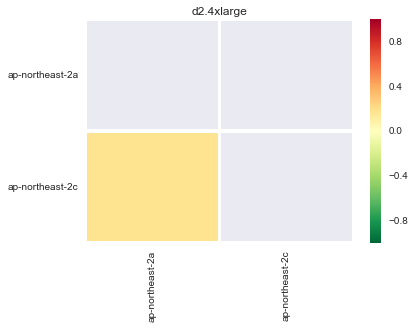

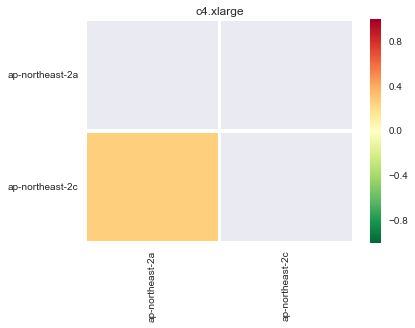

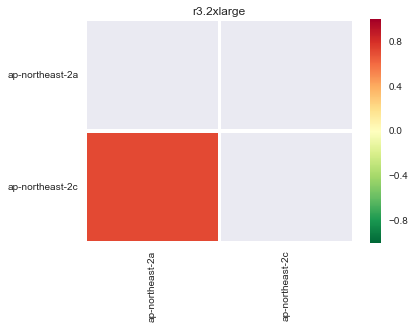

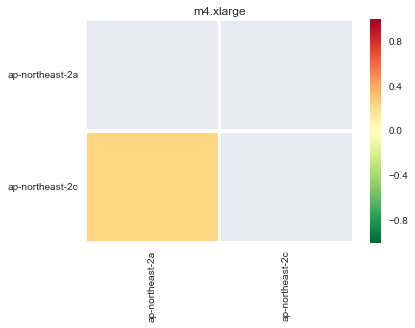

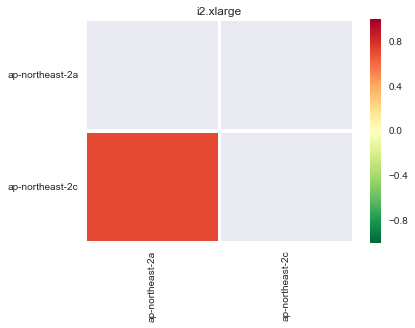

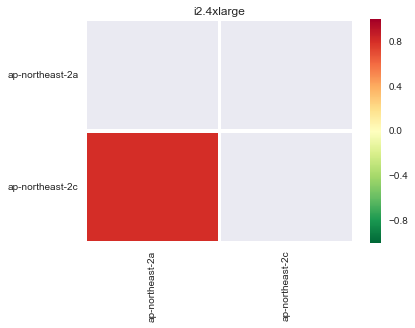

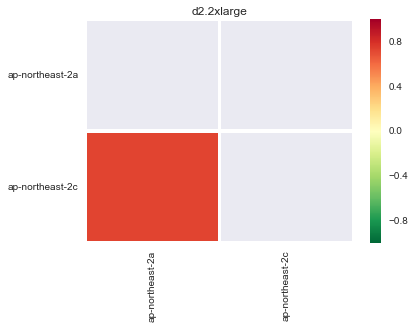

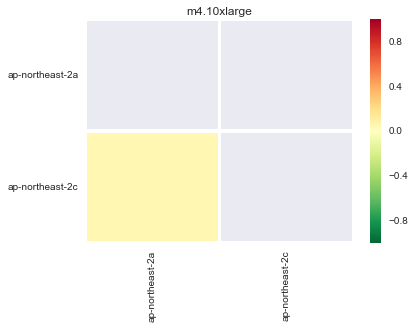

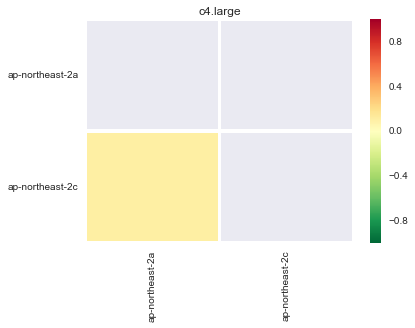

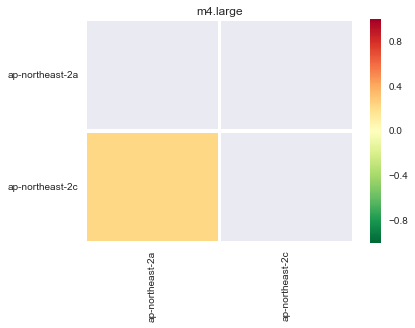

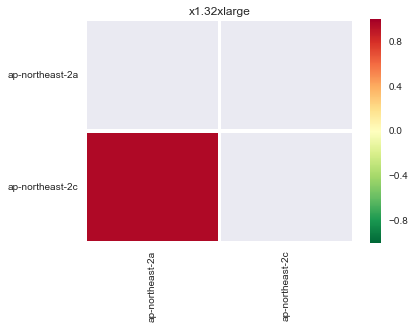

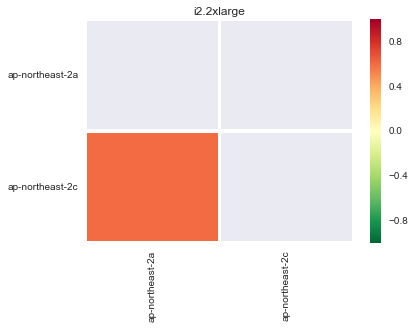

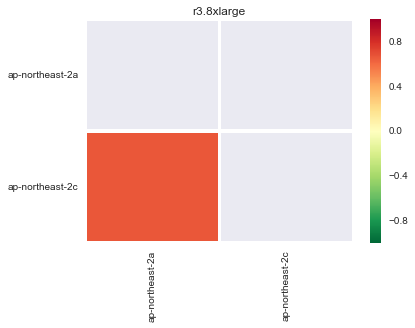

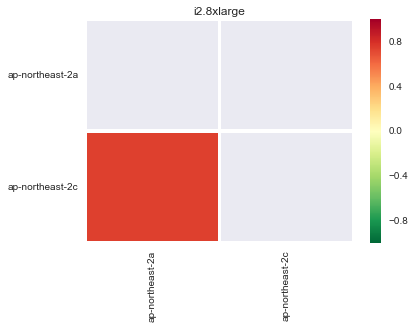

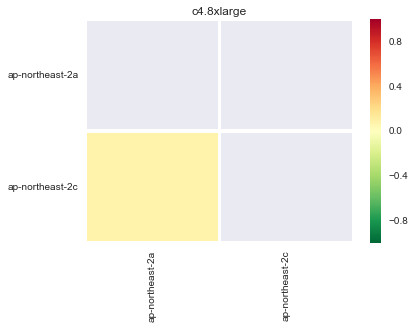

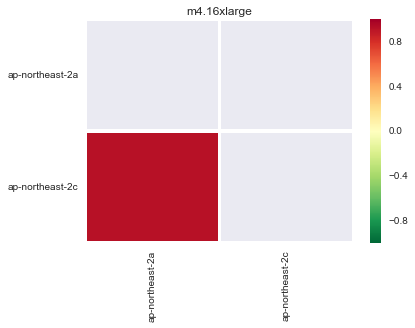

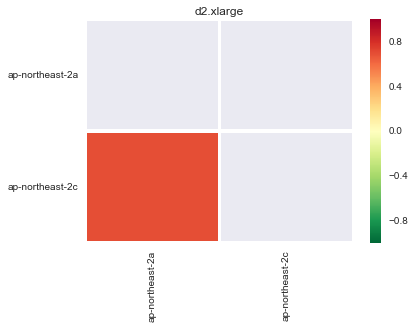

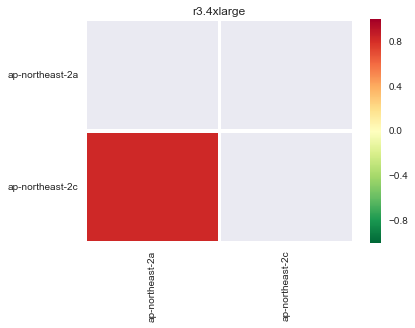

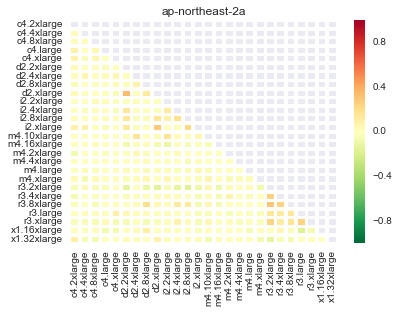

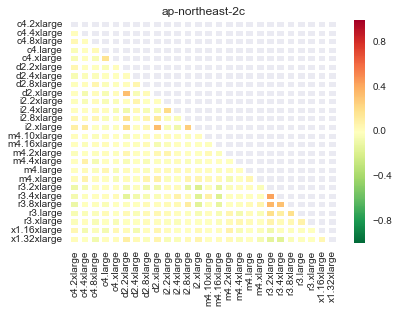

In [61]:
#NORMALIZE THE DATA HERE

typedfsN = typedfs
zonedfsN = zonedfs

for key in typedfsN:
    #typedfs[key].index = typedfs[key].TimeStamp
    #typedfs[key]       = typedfs[key].drop(['TimeStamp'],axis=1)
    #Normalize data
        #typedfs[key] = typedfs[key].apply(lambda row: np.log(row).diff(), axis=0 )
    typedfsN[key] = typedfsN[key].diff(axis=0)
    corrGraph(key, typedfsN[key])
    
for key in zonedfsN:
    #zonedfs[key].index = zonedfs[key].TimeStamp
    #zonedfs[key]       = zonedfs[key].drop(['TimeStamp'],axis=1)
    #Normalize data
        #zonedfs[key] = zonedfs[key].apply(lambda row: np.log(row).diff(), axis=0 )
    zonedfsN[key] = zonedfsN[key].diff(axis=0)
    corrGraph(key, zonedfsN[key])

In [ ]:
#  The reason for some grey rows, 
#  is because those values are all zero meaning
#  the price did not change ever for that time series.

print(typedfs['c3.large']['sa-east-1b'].head(20))

--------
### AVGS, MINS, MAXs vs REAL Prices

In [ ]:
#NORMALIZE THE DATA HERE

tavg = typedfs
zavg = zonedfs

for key in tavg:
    #tavg[key] = tavg[key].diff(axis=0)
  
    
for key in zavg:
    #zavg[key] = zavg[key].diff(axis=0)


### Reference:

[pattern matching over time series data](http://stats.stackexchange.com/questions/136091/sequential-pattern-matching-in-time-series-data)